## Tox21 Structure-Activity Relationship Models

#### Tox21 Challenge

The Toxicology in the 21st Century (Tox21) program is a federal collaboration between the NIH, EPA, and FDA.  Using the their high-throughput robotic screening system, they tested a collection of over 10,000 environmental chemicals and approved drugs for their potential to disrupt processes in the human body that may lead to negative health effects.  This collection of data is known as the Tox21 10K library.

Computational models are a potential alternative to in vivo and in vitro experiments, but they usually suffer from insufficient accuracy and are not as reliable as biological experiments.  Thus, in 2014, the collaboration announced the [Tox21 Data Challenge](https://tripod.nih.gov/tox21/challenge/about.jsp) to "crowdsource" data analysis by independent researchers to reveal how well they can predict the toxicity of compounds using only chemical structure data. 
 
The challenge uses data from 12 assays run against the Tox 21 10K library to build models.  Subchallenges included predicting individual assays, groups of assays of a particular type (either nuclear receptor signaling or stress response), or the grand challenge of all the assays together.  Our group will be using this dataset for our project, taking on the subchallenge of evaluating a single assay.

#### NR-AhR Assay

Thankfully for humans, there are far more non-toxic compounds than toxic ones in the environment.  However, this implies that all of the datasets in the Tox21 10K library are inherently imbalanced.  

For our project, we chose the dataset for the NR-AhR assay because it was one of the least imbalanced datasets in the Tox21 challenge.  We also chose the assay for better explainability.  The most common ligands for the aryl hydrocarbon receptor, as its name implies, usually consist of one or more aromatic rings, which is readily identifiable in a molecular structure, even for audiences with non-chemistry backgrounds. 

In [1]:
# import libraries needed
import pandas as pd
import numpy as np
import random
from reportlab.graphics import renderPDF, renderPM

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.ipython_useSVG = True

from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, NuSVC, LinearSVC

from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report, roc_auc_score

from exploration import top_features, top_negatives, top_false_positives, top_false_negatives, top_positives
from spe_vectorizers import spe_featurizer, spe_featurizer2, atom_featurizer, kmer_featurizer
from kaggle_chem import ecfp_featurizer, oned_featurizer

%matplotlib inline
import matplotlib.pyplot as plt

### Data Wrangling

Here we import cleaned and standardized data for the Tox21 NR-AhR assay.  We used the train and score datasets as train and test data, respectively.  The dataset was wrangled in a separate notebook in this folder called **[1_data_wrangling.ipynb](https://github.com/LimaEchoAlpha/tox21_ml_class_project/blob/main/final_code/1_data_wrangling.ipynb)**.

In [2]:
train = pd.read_csv('../processed_data/nr_ahr_std_train.csv')

train_data = train.std_compounds
train_labels = train.label

print('Train data shape:', train_data.shape)
print('Train labels shape:', train_labels.shape)

active_train = train_data[train_labels == 1].reset_index(drop=True)
inactive_train = train_data[train_labels == 0].reset_index(drop=True)

print('Active compounds:', len(train_labels[train_labels == 1]))
print('Inactive compounds:', len(train_labels[train_labels == 0]))
print('Inactive : Active ~', len(train_labels[train_labels == 0]) // len(train_labels[train_labels == 1]))

Train data shape: (6709,)
Train labels shape: (6709,)
Active compounds: 761
Inactive compounds: 5948
Inactive : Active ~ 7


In [3]:
test = pd.read_csv('../processed_data/nr_ahr_test_std.csv')
#test.head()

test_data = test.std_compounds
test_labels = test.label

print('Test data shape:', test_data.shape)
print('Test labels shape:', test_labels.shape)

print('Active compounds:', len(test_labels[test_labels == 1]))
print('Inactive compounds:', len(test_labels[test_labels == 0]))
print('Inactive : Active ~', len(test_labels[test_labels == 0]) // len(test_labels[test_labels == 1]))

Test data shape: (607,)
Test labels shape: (607,)
Active compounds: 71
Inactive compounds: 536
Inactive : Active ~ 7


### Exploratory Data Analysis

Before we begin our analysis, we want to visualize our data.  First, let's look at a few examples of known ligands of the aryl hydrocarbon receptor.

The aryl hydrocarbon receptor is a protein that functions primarily as a sensor of xenobiotic chemicals and regulates enzymes that metabolize these chemicals.  Known ligands include natural plant flavonoids, indoles, synthetic polycylclic aromatic hydrocarbons, and dioxin-like compounds.

Sources: [Wikipedia](https://en.wikipedia.org/wiki/Aryl_hydrocarbon_receptor), doi: [10.1016/j.cotox.2018.11.005](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6709982/)

In [4]:
ahr_ligands = ['OC1=C(C2=CC=C(O)C(O)=C2)OC3=C(C(O)=CC(O)=C3)C1=O', 'O=CCC1=CNC2=C1C=CC=C2', 
               'ClC1=C(Cl)C=C2C(OC3=CC(Cl)=C(Cl)C=C3O2)=C1', 'O=S(CC1=NC=C(C(OC)=C1C)C)C2=NC3=C(N2)C=CC(OC)=C3']
ligand_mols = [Chem.MolFromSmiles(i) for i in ahr_ligands]

ahr_ligand_names = ['Quercetin', 'Indole-3-acetaldehyde', 'TCDD', 'Omeprazole']

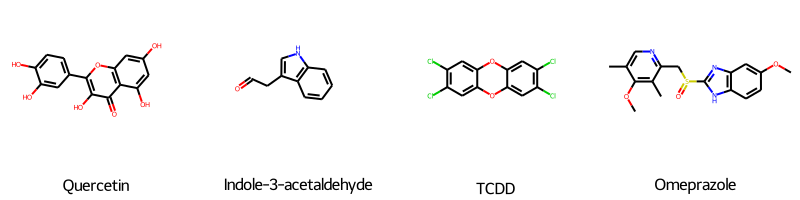

In [5]:
Chem.Draw.Chem.Draw.MolsToGridImage(ligand_mols, molsPerRow=4, subImgSize=(200,200), legends=ahr_ligand_names)

Now that we have an idea of what types of chemicals are likely to be ligands, we'll visualize 5 random samples of active and inactive compounds from the NR-AhR dataset.

In [6]:
# make a list of random samples
random.seed(0)
i_active = [random.randint(0, 761) for i in range(5)]
i_inactive = [random.randint(0, 5948) for i in range(5)]

# make mol files from random sample list
active_mols = [Chem.MolFromSmiles(active_train[i]) for i in i_active]
inactive_mols = [Chem.MolFromSmiles(inactive_train[i]) for i in i_inactive]

We see lots of aromatic rings in the active compounds, which is what we expect:

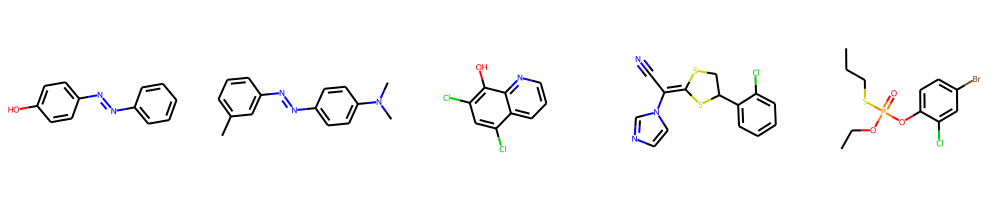

In [7]:
Chem.Draw.Chem.Draw.MolsToGridImage(active_mols, molsPerRow=5, subImgSize=(200,200))

Some aromatic rings show up in the inactive compounds as well, although not as many as the active:

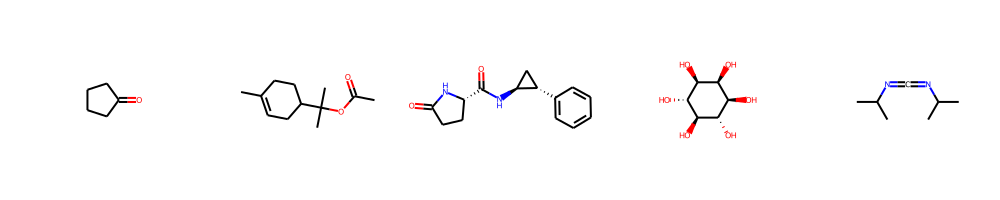

In [8]:
Chem.Draw.Chem.Draw.MolsToGridImage(inactive_mols, molsPerRow=5, subImgSize=(200,200))

### Featurization

The Tox21 dataset comes in two different file formats for the chemical structure data: SMILES (Simplified Molecular-Input Line-Entry System) and SDF (Spatial Data File).  For our project, we chose to focus on SMILES.  Because of its string format, creating features from SMILES strings is akin to vectorizing text documents.

We explored five featurization techniques: atom-wise, k-mer (specifically 4-mers), SPE (SMILES Pair Encoding), ECFP (Extended Circular Fingerprints), and one-dimensional molecular descriptors.  

For the first three techniques, we used tokenizers described in a [paper](https://github.com/LimaEchoAlpha/tox21_ml_class_project/blob/main/references/li2021_smiles_pair_encoding.pdf) by Li, et al, which they made available in their [GitHub repository](https://github.com/XinhaoLi74/SmilesPE).  Once the SMILES strings were tokenized, we used `CountVectorizer` from sci-kit learn to generate a matrix of feature vectors for machine learning.

The last two techniques are conventional methods used in the field.  For these, we used a traditional cheminformatics package called RDKit.  Here is a [link](https://www.kaggle.com/vladislavkisin/tutorial-ml-in-chemistry-research-rdkit-mol2vec) to the tutorial we followed.

We wrote a model of featurizers for each group of techniques in a separate notebook in this folder called **[2_featurizers.ipynb](https://github.com/LimaEchoAlpha/tox21_ml_class_project/blob/main/final_code/2_featurizers.ipynb)**.



### Model Matrix Experiment

Next we ran a model matrix experiment to explore how the different featurizations perform using different classification models.  We chose models that fall into two different categories of approaches: similarity-based (k-nearest neighbors, SVM) and features-based (Bernoulli Naive Bayes, Random Forest, Logistic Regression).

To make the comparisons between the models more fair, we ran grid search cross-validation on all the model and featurizer combinations to identify the parameters for the best model for each.  We chose recall as our scoring strategy because for this application, false negatives are far worse than false positives.  Labeling an inactive compound as active would constitute an overabundance of caution, but labeling an active compound as inactive can be disastrous.  

We ran our model matrix experiment in separate notebooks in this folder called **[3_model_matrix.ipynb](https://github.com/LimaEchoAlpha/tox21_ml_class_project/blob/main/final_code/3_model_matrix.ipynb)** and **[3_model_matrix_conventional.ipynb](https://github.com/LimaEchoAlpha/tox21_ml_class_project/blob/main/final_code/3_model_matrix_conventional.ipynb)**.


### Experiment Results

To visualize our experiment results, we plot a comparison of the recall scores for active and inactive compounds, along with the ROC-AUC scores for each model.  

We include the ROC-AUC score because it was used to evaluate the models for the Tox21 challenge.  However, we discovered that this metric can be misleading, especially given the imbalance in our dataset.  To put it in context, if our model did nothing but label every datapoint as inactive, we will still come out with ~88% accuracy.  In general, the recall score for most of the model-featurizer combinations we tested were skewed toward inactive compounds; not the most desirable result.

Our results also highlight the curse of dimensionality for some featurization techniques.  Because the problem of searching through space gets much harder with higher dimensionality, algorithms that learn by partitioning its vector space (e.g. k-nearest neighbors, linear methods, decision trees) especially suffer.  It's not surprising, then, that the featurization methods with less features overall like atom-wise and ECFP tended to perform better in those models than SPE or k-mer.

Our results also show the advantage of using features based on two-dimensional molecular representations rather than one-dimensional molecular descriptors.  The molecular descriptor featurizer simply did not have enough information to do well in two of the models (NB and SVM) and posted mediocre results in the other three mostly because it suffers the curse of dimensionality least by far out of all the featurizers tested.

In [9]:
# upload results dataset
matrix_model = pd.read_csv('../processed_data/model_matrix2.csv')
matrix_model = matrix_model.drop(['Unnamed: 0'], axis=1)

# group by featurizer
by_featurizer = matrix_model.groupby('featurizer')

matrix_model.head()

,featurizer,model,best_params,recall_0,recall_1,roc_auc
0,spe,bnb,{'alpha': 0.1},0.863806,0.492958,0.820685
1,spe,rf,"{'max_depth': None, 'n_estimators': 100}",0.975746,0.098592,0.821185
2,spe,logreg,"{'C': 0.5, 'multi_class': 'auto', 'solver': 'l...",0.983209,0.197183,0.818951
3,spe,knn,{'n_neighbors': 1},0.902985,0.295775,0.599380
4,spe,svm,"{'C': 1, 'kernel': 'linear', 'probability': True}",0.934701,0.380282,0.786184


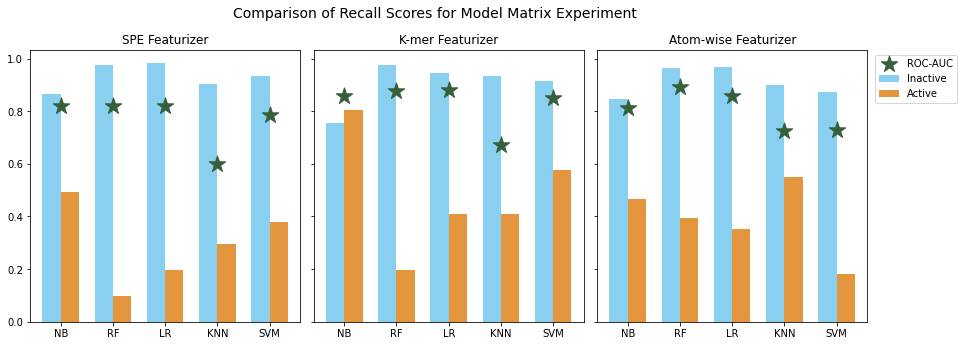

In [10]:
featurizer_methods = matrix_model.featurizer.unique()
labels = ['NB', 'RF', 'LR', 'KNN', 'SVM']
featurizer_names = ['SPE', 'K-mer', 'Atom-wise']

fig, ax = plt.subplots(nrows=1 , ncols=3, figsize=(15, 5), sharey=True)
fig.subplots_adjust(wspace=0.05)


for i in range(len(featurizer_methods)):

    feature_group = by_featurizer.get_group(featurizer_methods[i])
    inactive_recall = feature_group['recall_0']
    active_recall = feature_group['recall_1']
    model_roc_auc = feature_group['roc_auc']

    x = np.arange(len(labels))  # the label locations
    width = 0.35  # the width of the bars

    ax[i].bar(x - width/2, inactive_recall, width, label='Inactive', color='#89CFF0')
    ax[i].bar(x + width/2, active_recall, width, label='Active', color='#E3963E')
    ax[i].scatter(labels, model_roc_auc, marker='*', s=300, color='#355E3B', label='ROC-AUC', zorder=2)

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax[i].set_title(f'{featurizer_names[i]} Featurizer')
    ax[i].set_xticks(x)
    ax[i].set_xticklabels(labels)

plt.legend(loc='upper right', bbox_to_anchor=(1.35, 1))
plt.suptitle('Comparison of Recall Scores for Model Matrix Experiment', y=1, fontsize=14)

#plt.savefig('../images/model_matrix2.png')
plt.show()

#### Plotting the model matrix experiment results for the conventional RDKit featurization methods

In [11]:
# upload results dataset 
conventional = pd.read_csv('../processed_data/model_matrix_conventional.csv')
conventional = conventional.drop(['Unnamed: 0'], axis=1)

# group by featurizer
by_method = conventional.groupby('featurizer')

conventional.head()

,featurizer,model,best_params,recall_0,recall_1,roc_auc
0,ecfp,bnb,{'alpha': 1e-10},0.652985,0.887324,0.843835
1,ecfp,rf,"{'max_depth': 100, 'n_estimators': 100}",0.979478,0.253521,0.890740
2,ecfp,logreg,"{'C': 0.5, 'multi_class': 'auto', 'solver': 'l...",0.945896,0.422535,0.858682
3,ecfp,knn,{'n_neighbors': 1},0.912313,0.549296,0.730805
4,ecfp,svm,"{'C': 0.1, 'kernel': 'linear', 'probability': ...",0.977612,0.239437,0.850983


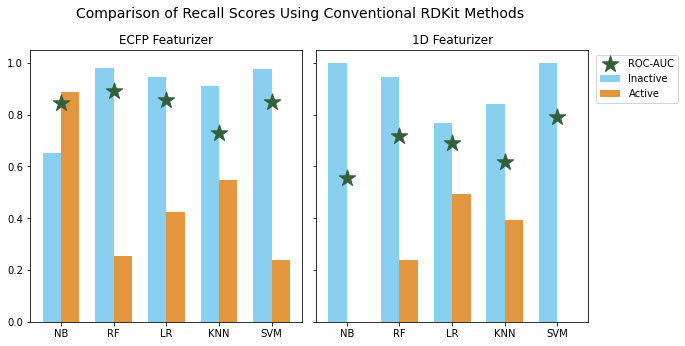

In [12]:
conventional_methods = conventional.featurizer.unique()
method_names = ['ECFP', '1D']

fig, ax = plt.subplots(nrows=1 , ncols=2, figsize=(10, 5), sharey=True)
fig.subplots_adjust(wspace=0.05)


for i in range(len(conventional_methods)):

    feature_group = by_method.get_group(conventional_methods[i])
    inactive_recall = feature_group['recall_0']
    active_recall = feature_group['recall_1']
    model_roc_auc = feature_group['roc_auc']

    x = np.arange(len(labels))  # the label locations
    width = 0.35  # the width of the bars

    ax[i].bar(x - width/2, inactive_recall, width, label='Inactive', color='#89CFF0')
    ax[i].bar(x + width/2, active_recall, width, label='Active', color='#E3963E')
    ax[i].scatter(labels, model_roc_auc, marker='*', s=300, color='#355E3B', label='ROC-AUC', zorder=2)

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax[i].set_title(f'{method_names[i]} Featurizer')
    ax[i].set_xticks(x)
    ax[i].set_xticklabels(labels)

plt.legend(loc='upper right', bbox_to_anchor=(1.35, 1))
plt.suptitle('Comparison of Recall Scores Using Conventional RDKit Methods', y=1, fontsize=14)

#plt.savefig('../images/conventional.png')
plt.show()

### Random Oversampling 

To explore how the imbalance in our dataset is affecting our results, we applied a random oversampling technique to the NR-AhR data.  We chose to oversample rather than undersample because we did not want to lose any information from our dataset.  After oversampling, we ran the same models with the same parameters as the model matrix experiment.

We ran our oversampled model matrix experiment in a separate notebook in this folder called **[4_models_oversampled.ipynb](https://github.com/LimaEchoAlpha/tox21_ml_class_project/blob/main/final_code/4_models_oversampled.ipynb)**.

#### Plotting the oversampled results for the *Li, et al* paper

In [13]:
# upload results dataset
matrix_model_over = pd.read_csv('../processed_data/model_matrix_over2.csv')

# group by featurizer
by_featurizer_over = matrix_model_over.groupby('featurizer')

matrix_model_over.head()

,Unnamed: 0,featurizer,model,best_params,recall_0,recall_1,roc_auc
0,0,spe,bnb,{'alpha': 0.1},0.785448,0.605634,0.766423
1,1,spe,rf,"{'max_depth': None, 'n_estimators': 100}",0.955224,0.253521,0.814668
2,2,spe,logreg,"{'C': 0.5, 'multi_class': 'auto', 'solver': 'l...",0.822761,0.661972,0.807599
3,3,spe,knn,{'n_neighbors': 1},0.902985,0.295775,0.599380
4,4,spe,svm,"{'C': 1, 'kernel': 'linear', 'probability': True}",0.843284,0.549296,0.777591


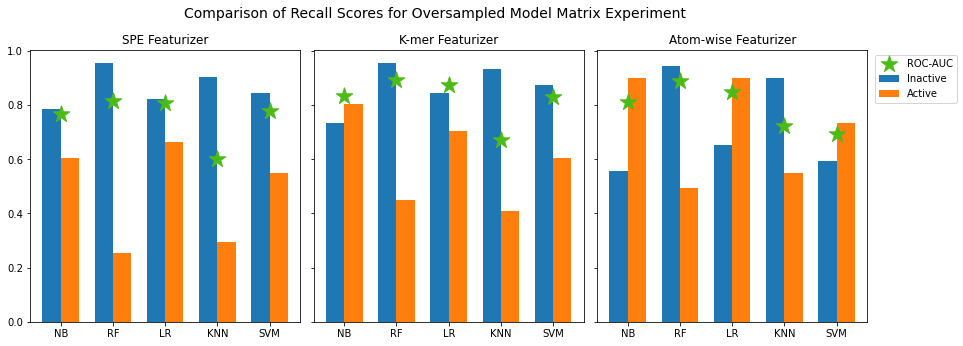

In [14]:
featurizer_methods_over = matrix_model_over.featurizer.unique()

fig, ax = plt.subplots(nrows=1 , ncols=3, figsize=(15, 5), sharey=True)
fig.subplots_adjust(wspace=0.05)


for i in range(len(featurizer_methods_over)):

    feature_group = by_featurizer_over.get_group(featurizer_methods_over[i])
    inactive_recall = feature_group['recall_0']
    active_recall = feature_group['recall_1']
    model_roc_auc = feature_group['roc_auc']

    x = np.arange(len(labels))  # the label locations
    width = 0.35  # the width of the bars

    ax[i].bar(x - width/2, inactive_recall, width, label='Inactive')
    ax[i].bar(x + width/2, active_recall, width, label='Active')
    ax[i].scatter(labels, model_roc_auc, marker='*', s=300, color='#4CBB17', label='ROC-AUC', zorder=2)

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax[i].set_title(f'{featurizer_names[i]} Featurizer')
    ax[i].set_xticks(x)
    ax[i].set_xticklabels(labels)

plt.legend(loc='upper right', bbox_to_anchor=(1.35, 1))
plt.suptitle('Comparison of Recall Scores for Oversampled Model Matrix Experiment', y=1, fontsize=14)

#plt.savefig('../images/model_matrix_over2.png')
plt.show()

#### Plotting the oversampled results for the conventional featurization methods

In [15]:
# upload results dataset
conventional_over = pd.read_csv('../processed_data/model_matrix_conventional_over.csv')
conventional_over = conventional_over.drop(['Unnamed: 0'], axis=1)

# group by featurizer
by_method_over = conventional_over.groupby('featurizer')

conventional_over.head()

,featurizer,model,best_params,recall_0,recall_1,roc_auc
0,ecfp,bnb,{'alpha': 1e-10},0.576493,0.971831,0.843678
1,ecfp,rf,"{'max_depth': 100, 'n_estimators': 100}",0.958955,0.450704,0.889663
2,ecfp,logreg,"{'C': 0.5, 'multi_class': 'auto', 'solver': 'l...",0.722015,0.845070,0.857132
3,ecfp,knn,{'n_neighbors': 1},0.912313,0.549296,0.730805
4,ecfp,svm,"{'C': 0.1, 'kernel': 'linear', 'probability': ...",0.716418,0.816901,0.846594


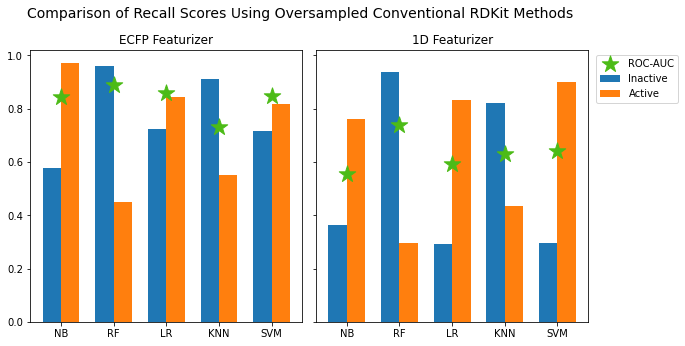

In [16]:
conventional_methods_over = conventional_over.featurizer.unique()

fig, ax = plt.subplots(nrows=1 , ncols=2, figsize=(10, 5), sharey=True)
fig.subplots_adjust(wspace=0.05)


for i in range(len(conventional_methods_over)):

    feature_group = by_method_over.get_group(conventional_methods_over[i])
    inactive_recall = feature_group['recall_0']
    active_recall = feature_group['recall_1']
    model_roc_auc = feature_group['roc_auc']

    x = np.arange(len(labels))  # the label locations
    width = 0.35  # the width of the bars

    ax[i].bar(x - width/2, inactive_recall, width, label='Inactive')
    ax[i].bar(x + width/2, active_recall, width, label='Active')
    ax[i].scatter(labels, model_roc_auc, marker='*', s=300, color='#4CBB17', label='ROC-AUC', zorder=2)

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax[i].set_title(f'{method_names[i]} Featurizer')
    ax[i].set_xticks(x)
    ax[i].set_xticklabels(labels)

plt.legend(loc='upper right', bbox_to_anchor=(1.35, 1))
plt.suptitle('Comparison of Recall Scores Using Oversampled Conventional RDKit Methods', y=1, fontsize=14)

#plt.savefig('../images/conventional_over.png')
plt.show()

### Model Exploration

We wanted to try to explain some of our mediocre results from the matrix model experiment, especially using the tokenizers from the *Li, et al* paper.  We wrote a module of functions to explore our models in a separate notebook in this folder called **[5_model_exploration.ipynb](https://github.com/LimaEchoAlpha/tox21_ml_class_project/blob/main/final_code/5_model_exploration.ipynb)**.

#### Top Features per Class

Our first exploration examines the top 5 features for each class in the Naive Bayes model based on the probability of the features given the class.  Below we visualize the results as a heatmap with the y-axis denoting the top 5 features for inactive and active compounds, respectively.

The main takeaway from this exploration is that many top features are shared between the active and inactive classes.  This explains why the classification is mediocre; the top features are not distinct.  Examining the top features, however, we see that they are very common fragments: for example, C appears as a top feature in the SPE model, but every organic compound contains C.  One fix we can apply in the future is to use molecular "stop words" or use `TfidfVectorizer` instead of `CountVectorizer` to make features.

##### SPE Featurizer

In [17]:
# generate features
x_spe, x_spe_test, spe_vocab = spe_featurizer(train_data, test_data)

print(x_spe.shape)
print(x_spe_test.shape)

(6709, 2378)
(607, 2378)


Results for the Naive Bayes Model using SPE Featurizer:


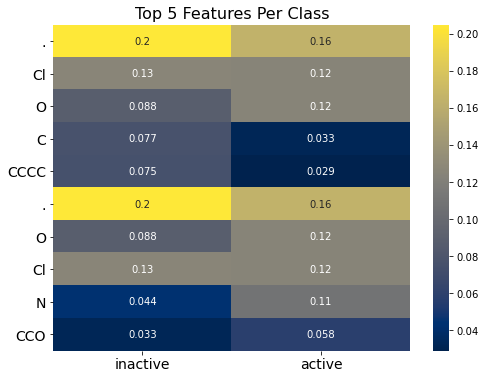

In [18]:
print('Results for the Naive Bayes Model using SPE Featurizer:')
top_features(x_spe, train_labels, spe_vocab, {'alpha': 0.1}, 'spe_top_features')

##### K-mer Featurizer

In [19]:
# generate features
x_kmer, x_kmer_test, kmer_vocab = kmer_featurizer(train_data, test_data)

print(x_kmer.shape)
print(x_kmer_test.shape)

(6709, 7831)
(607, 7831)


Results for the Naive Bayes Model using K-mer Featurizer:


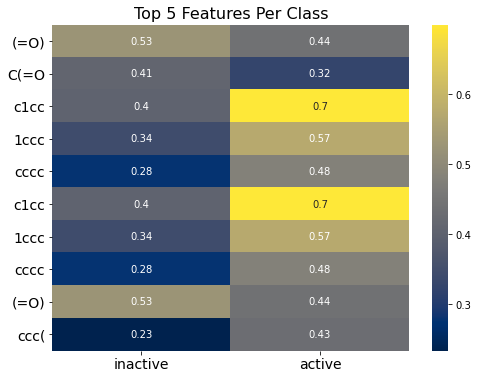

In [22]:
print('Results for the Naive Bayes Model using K-mer Featurizer:')
top_features(x_kmer, train_labels, kmer_vocab, {'alpha':0.1}, 'kmer_top_features')

##### Atom-wise Featurizer

In [23]:
# generate features
x_atom, x_atom_test, atom_vocab = atom_featurizer(train_data, test_data)

print(x_atom.shape)
print(x_atom_test.shape)

(6709, 131)
(607, 131)


Results for the Naive Bayes Model using Atom-wise Featurizer:


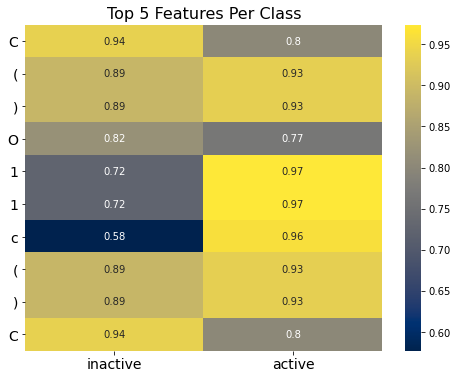

In [24]:
print('Results for the Naive Bayes Model using Atom-wise Featurizer:')
top_features(x_atom, train_labels, atom_vocab, {'alpha':1e-10}, 'atom_top_features')

#### Visual Confusion Matrix

The second exploration we performed focuses on the compounds with the highest posterior probability in each of the four quadrants of a confusion matrix: negatives, positives, false negatives, and false positives.  Here we want to visualize where and how the model is being tripped up.  We analyzed the Naive Bayes model using SPE featurization because it had a surprisingly mediocre performance in our matrix model experiment.

In [25]:
# find indices for top compounds in each quadrant
spe_neg = top_negatives(x_spe, train_labels, x_spe_test, test_labels, {'alpha':0.1})
spe_fpos = top_false_positives(x_spe, train_labels, x_spe_test, test_labels, {'alpha':0.1})
spe_fneg = top_false_negatives(x_spe, train_labels, x_spe_test, test_labels, {'alpha':0.1})
spe_pos = top_positives(x_spe, train_labels, x_spe_test, test_labels, {'alpha':0.1})

In [26]:
# create mols for each quadrant
spe_neg_mols = [Chem.MolFromSmiles(test_data[i]) for i in spe_neg]
spe_fpos_mols = [Chem.MolFromSmiles(test_data[i]) for i in spe_fpos]
spe_fneg_mols = [Chem.MolFromSmiles(test_data[i]) for i in spe_fneg]
spe_pos_mols = [Chem.MolFromSmiles(test_data[i]) for i in spe_pos]

##### Positives

The compounds we see here are consistent with what we saw in our exploratory data analysis: lots of aromatic rings.

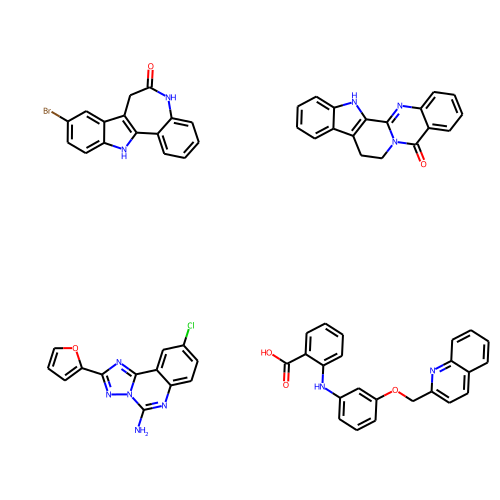

In [27]:
# POSITIVE QUADRANT
Chem.Draw.Chem.Draw.MolsToGridImage(spe_pos_mols, molsPerRow=2, subImgSize=(250,250))

##### Negatives

Also consistent with our exploratory data analysis, we see the occasional aromatic ring.

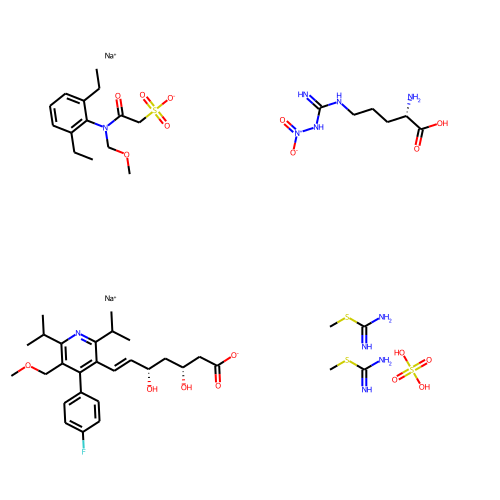

In [28]:
# NEGATIVE QUADRANT
Chem.Draw.Chem.Draw.MolsToGridImage(spe_neg_mols, molsPerRow=2, subImgSize=(250,250))

##### False Positives

Here we start to see why the model does not perform as well.  These compounds are tricky - they contain a lot of rings, even if they are not active.  They would fool a human chemist, let alone a simple machine learning model.

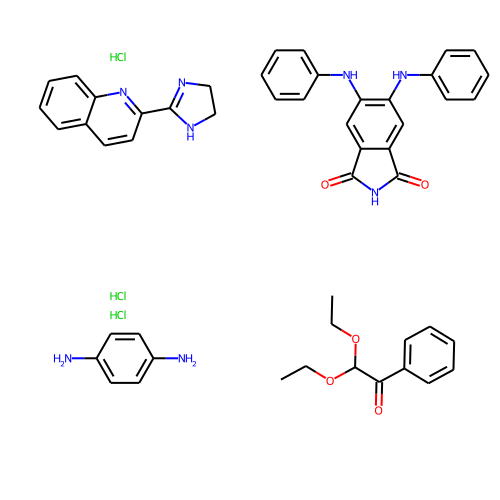

In [30]:
# FALSE POSITIVE QUADRANT
Chem.Draw.Chem.Draw.MolsToGridImage(spe_fpos_mols, molsPerRow=2, subImgSize=(250,250))

##### False Negatives

Here we start to realize that our simple machine learning model is in over its head.  A human chemist will have no trouble identifying these compounds as active, yet the model misclassifies them badly.  

In reality, chemistry is much more complicated and nuanced than a two-dimensional SMILES string can represent.

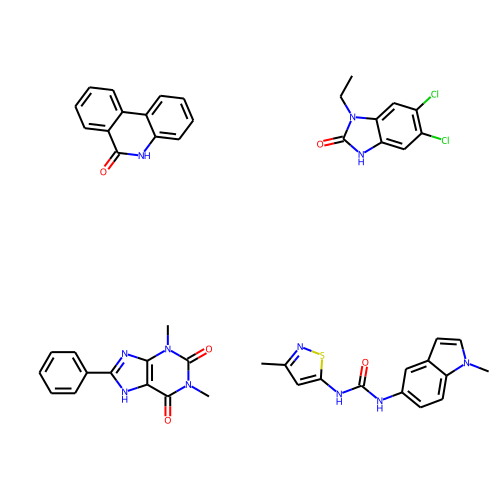

In [32]:
# FALSE NEGATIVE
Chem.Draw.Chem.Draw.MolsToGridImage(spe_fneg_mols, molsPerRow=2, subImgSize=(250,250))